# Fig4

## Reqs

To run this notebook you have to download / get following files in addition to the files already present in the repository :
- `data/clinvar/clinvar_mutation_context.csv` available from Zenodo
- `data/cosmic/cosmic_mutation_context.csv` available from Zenodo
- `data/somamutdb/somamutdb_mutation_context.csv` available from Zenodo
- `hg38/kmer_counts_3N.csv` available from github and Zenodo
- `hg38/kmer_counts_5N.csv` available from github and Zenodo
- `hg38/kmer_counts_7N.csv` available from Zenodo
- `hg38/kmer_counts_9N.csv` available from Zenodo
- `hg38/kmer_counts_11N.csv` available from Zenodo

In [1]:
import polars as pl
from utils import utils, load_data
from pathlib import Path

PROJECT_DIR = Path().absolute().parent

In [2]:
datas = pl.concat(
    [
        pl.read_csv(
            PROJECT_DIR / "data" / db / f"{db}_mutation_context.csv",
            separator=",",
            schema_overrides={"chromosome": pl.Utf8},
        )
        .filter(pl.col("type") == "silent")
        .with_columns(
            pl.col("context").str.slice(4, 3).alias("3N"),
            pl.col("context").str.slice(3, 5).alias("5N"),
            pl.col("context").str.slice(2, 7).alias("7N"),
            pl.col("context").str.slice(1, 9).alias("9N"),
            pl.col("context").str.slice(0, 11).alias("11N"),
            pl.lit(db).alias("db"),
        )
        for db in ["cosmic", "clinvar", "somamutdb"]
    ],
    how="diagonal_relaxed",
).filter(~pl.col("context").str.contains("N"))

kmer3 = load_data.get_kmer_df(PROJECT_DIR / "hg38", 3)["context", "frequencies"]
kmer5 = load_data.get_kmer_df(PROJECT_DIR / "hg38", 5)["context", "frequencies"]
kmer7 = load_data.get_kmer_df(PROJECT_DIR / "hg38", 7)["context", "frequencies"]
kmer9 = load_data.get_kmer_df(PROJECT_DIR / "hg38", 9)["context", "frequencies"]
kmer11 = load_data.get_kmer_df(PROJECT_DIR / "hg38", 11)["context", "frequencies"]

In [5]:
from scipy import stats
import matplotlib.pyplot as plt

GENERATE_RESULTS = True

MOTIF_SIZES = [3, 5, 7, 9, 11]
KMERS = {3: kmer3, 5: kmer5, 7: kmer7, 9: kmer9, 11: kmer11}

# DBS from constants: Ssc=cosmic, Ssn=somamutdb, Sg=clinvar
DB_MAP = {"Ssc": "cosmic", "Ssn": "somamutdb", "Sg": "clinvar"}
LABELS = {"Ssc": r"$S_{SC}$", "Ssn": r"$S_{SN}$", "Sg": r"$S_G$"}
COLORS = {"Ssc": "tab:blue", "Ssn": "tab:orange", "Sg": "tab:green"}



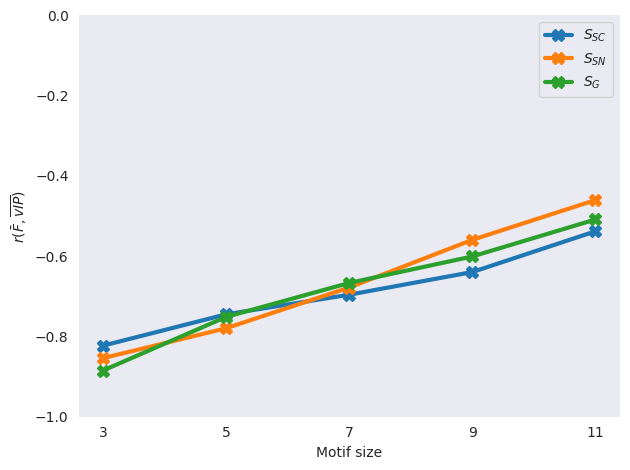

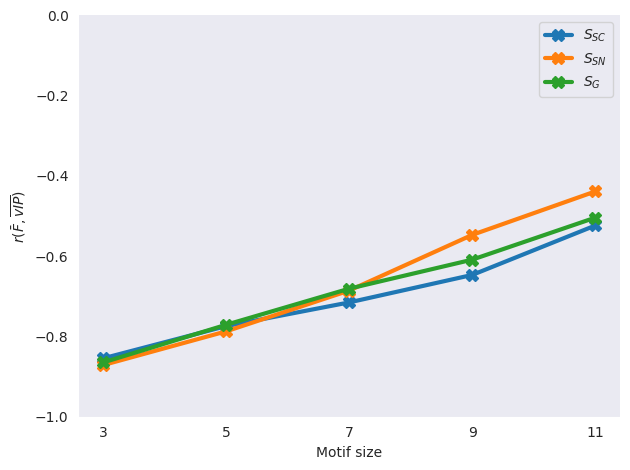

In [8]:
stat_methods = [stats.spearmanr, stats.pearsonr]

for stat_method in stat_methods:
    results = {}  # label -> list of corr r per motif size
    for label, db in DB_MAP.items():
        results[label] = []
        db_data = datas.filter(pl.col("db") == db)
        for n in MOTIF_SIZES:
            context_col = f"{n}N"
            aggregated = utils.aggregate_data(
                db_data.group_by(["db", context_col]).len(),
                KMERS[n],
                on=["db", "context"],
                over=["db"],
                context_col=context_col,
            ).drop_nulls()
            r, _ = stat_method(aggregated["F"], aggregated["vip"])
            results[label].append(r)

    fig, ax = plt.subplots()
    for label, corrs in results.items():
        ax.plot(
            MOTIF_SIZES,
            corrs,
            marker="X",
            linewidth=3,
            markersize=8,
            color=COLORS[label],
            label=LABELS[label],
        )

    ax.set_ylim(-1, 0)
    ax.grid(False)
    ax.set_xlabel("Motif size")
    ax.set_ylabel(r"$r(\bar{F}, \overline{vIP})$" )
    ax.set_xticks([3, 5, 7, 9, 11])
    ax.legend()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.tight_layout()

    if GENERATE_RESULTS:
        output_path = PROJECT_DIR / "outputs"/ "datasets"/ f"{stat_method.__name__}_correlation_evolution.svg"
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_path, bbox_inches="tight")

plt.show()